# Generate 3D structures using different parameters

# 1. Define some functions

# 1.1 Generate target synthetic 3d and their 2d structure

In [1]:
import numpy as np
from scipy.ndimage import gaussian_filter as gaussian
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error
from skimage.filters import gaussian  # Import Gaussian filter function from skimage.filters module
import matplotlib.pyplot as plt  # Import matplotlib.pyplot for visualization

# Function to generate a synthetic 3D structure
def generate_synthetic_3d_structure(sigma, quantile, shape=(300, 300, 60)):
    random_field = np.random.rand(*shape)  # Generate a random 3D array with the given shape
    filtered_field = gaussian(random_field, sigma=sigma, mode='reflect', preserve_range=True)  
    # Apply Gaussian filter to smooth the random field
    threshold = np.quantile(filtered_field, quantile)  # Compute the quantile threshold of the filtered field
    binary_field = (filtered_field > threshold).astype(int)  
    # Binarize the field based on the threshold to generate a synthetic 3D structure
    # 0 represents void space, 1 represents solid space
    return binary_field  # Return the generated 3D binary structure

# Function to extract 2D slices from the 3D binary structure
def extract_2d_slices(binary_field):
    slices = []
    for i in range(binary_field.shape[2]):
        slices.append(binary_field[:, :, i])
    return slices


# 1.2 Get the distance transform histogram

## Get the distance transform image of the input image

In [2]:
# Function to distance transform image
def transform(img):
    # Check if the image is in color (3 channels) and convert to grayscale if needed
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    # Ensure the image is in 'uint8' format
    if img.dtype != 'uint8':
        img = img.astype('uint8')
        
    # Apply thresholding to convert image to binary
    _, img_binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # Apply distance transform to the binary image
    transform_img = cv2.distanceTransform(img_binary, cv2.DIST_L2, 3)
    return transform_img, img_binary

## Get the histogram of transform image with same bins_edge

In [3]:
#In order to unify the Bin_edges of the distance transform histogram, all synthetic data are used to calculate Bin_edges
def calculate_bin_edges(all_slices, num_bins):
    all_transform_imgs = []
    
    # each 2D slice and store the results
    for slice_2d in all_slices:
        transform_img, _ = transform(slice_2d)
        all_transform_imgs.append(transform_img)
    
    # Combine all transform images values into one large array
    combined_data = np.concatenate([img.ravel() for img in all_transform_imgs])
    min_val = np.min(combined_data)
    max_val = np.max(combined_data)

    # Generate bin edges based on the combined data array
    return np.linspace(min_val, max_val, num_bins + 1)

In [4]:
#function to get the histogram image used the calculated "bin_edges" to generate hisotgram of transform image
import cv2
import matplotlib.pyplot as plt
import numpy as np

def hist_transform(img, bin_edges):
    # Apply the transformation function to the image
    transform_img, img_binary = transform(img)
    
    # Calculate the histogram of the transformed image
    transform_hist_img, _ = np.histogram(transform_img, bins=bin_edges)
    
    return transform_img, transform_hist_img #return transform image and its histogram


## 1.3 Calculate the similarity of two histograms

In [5]:
# Function to calculate histogram similarity, the input are two histogram
def hist_similar(lh, rh):
    # Ensure both histograms have the same length, all of them are 50
    assert len(lh) == len(rh), "The lengths of both histograms must be the same"
    
    # Calculate the similarity between each corresponding bin and average the differences
    hist_similarity = sum(1 - (0 if l == r else float(abs(l - r)) / max(l, r)) for l, r in zip(lh, rh)) / len(lh)
    
    return hist_similarity

# 2. Using different parameters to generate

## 2.1 generate multiple 3D structures

In [6]:
# Set a series of value of the sigma and quantile to generate a lot of synthetic structure
sigma_values = [0.82, 1.55, 2.48, 5.96, 7.79]
quantile_values = [0.5, 0.5, 0.65, 0.7, 0.8 ]

if len(sigma_values) != len(quantile_values):
    print("The length of sigma and quantile are not equal")
else:
    print("The length of sigma and quantile are equal")


The length of sigma and quantile are equal


In [7]:
# Generate 3D structures and compute slices and bin edges
target_structures = []

for sigma, quantile in zip(sigma_values, quantile_values):
    structure = generate_synthetic_3d_structure(sigma=sigma, quantile=quantile)
    slices = extract_2d_slices(structure)
    bin_edges = calculate_bin_edges(slices, num_bins=50)
        
    # Store the information in a dictionary
    target_structures.append({
        'sigma': sigma,
        'quantile': quantile,
        'structure': structure,
        'slices': slices,
        'bin_edges': bin_edges
    })

# Print details of the generated structures
for item in target_structures:
    print(f"Sigma: {item['sigma']}, Quantile: {item['quantile']}")
    print(f"Structure shape: {item['structure'].shape}")
    print(f"Number of slices: {len(item['slices'])}")
    print(f"Bin edges: {item['bin_edges']}")

Sigma: 0.82, Quantile: 0.5
Structure shape: (300, 300, 60)
Number of slices: 60
Bin edges: [0.         0.112072   0.224144   0.336216   0.448288   0.56036
 0.672432   0.784504   0.896576   1.008648   1.12072001 1.23279201
 1.34486401 1.45693601 1.56900801 1.68108001 1.79315201 1.90522401
 2.01729601 2.12936801 2.24144001 2.35351201 2.46558401 2.57765601
 2.68972801 2.80180001 2.91387201 3.02594401 3.13801601 3.25008801
 3.36216002 3.47423202 3.58630402 3.69837602 3.81044802 3.92252002
 4.03459202 4.14666402 4.25873602 4.37080802 4.48288002 4.59495202
 4.70702402 4.81909602 4.93116802 5.04324002 5.15531202 5.26738402
 5.37945602 5.49152802 5.60360003]
Sigma: 1.55, Quantile: 0.5
Structure shape: (300, 300, 60)
Number of slices: 60
Bin edges: [0.         0.19423    0.38846001 0.58269001 0.77692001 0.97115002
 1.16538002 1.35961002 1.55384003 1.74807003 1.94230003 2.13653004
 2.33076004 2.52499004 2.71922005 2.91345005 3.10768005 3.30191006
 3.49614006 3.69037006 3.88460007 4.07883007 4.27

## 2.2 Bayesian Optimization with all slices with three acq

In [8]:
from bayes_opt import BayesianOptimization, UtilityFunction
import time

# Objective function
def objective_function(sigma, quantile, target_slices, target_bin_edges):
    generated_structure = generate_synthetic_3d_structure(sigma=sigma, quantile=quantile)
    generated_slices = extract_2d_slices(generated_structure)

    similarity_total = 0
    for target_slice, generated_slice in zip(target_slices, generated_slices):
        target_transform_img, target_transform_hist = hist_transform(target_slice, target_bin_edges)
        generated_transform_img, generated_transform_hist = hist_transform(generated_slice, target_bin_edges)
        similarity_total += hist_similar(target_transform_hist, generated_transform_hist)

    average_similarity = similarity_total / len(target_slices)
    return average_similarity


In [9]:
from bayes_opt import BayesianOptimization
from bayes_opt.util import UtilityFunction
import time

def run_bayesian_optimization(target_slices, target_bin_edges, pbounds, acq_function, init_points=40, n_iter=60):
    # Create an instance of UtilityFunction with the desired acquisition function
    utility_function = UtilityFunction(kind=acq_function)
    
    # Define the objective function
    def objective_function_wrapper(sigma, quantile):
        return objective_function(sigma, quantile, target_slices, target_bin_edges)
    
    # Initialize BayesianOptimization with the acquisition function
    optimizer = BayesianOptimization(
        f=objective_function_wrapper,
        pbounds=pbounds,
        verbose=2,
        random_state=1
    )

    # Start time measurement
    start_time = time.time()
    
    # Run the optimization
    optimizer.maximize(
        init_points=init_points,
        n_iter=n_iter
    )
    
    # End time measurement
    end_time = time.time()
    
    # Print results
    print(f"Acquisition Function: {acq_function}")
    print(f"Optimal sigma: {optimizer.max['params']['sigma']}")
    print(f"Optimal quantile: {optimizer.max['params']['quantile']}")
    print(f"Time taken: {end_time - start_time} seconds")
    print("")
    
    #save results
    optimal_sigma = optimizer.max['params']['sigma']
    optimal_quantile = optimizer.max['params']['quantile']
    execution_time = end_time - start_time
    
    return optimal_sigma,optimal_quantile,execution_time



In [10]:
results_acq = []

# Define the parameter bounds
pbounds = {
    'sigma': (0.1, 9.0),
    'quantile': (0.1, 0.9)
}

# List of acquisition functions to test
acq_functions = ['ucb', 'ei', 'poi']

# Run optimization for each acquisition function
for target_structure in target_structures:
    target_slices = target_structure['slices']
    target_bin_edges = target_structure['bin_edges']

    for acq_function in acq_functions:
        print(f"Running optimization for Sigma: {target_structure['sigma']}, Quantile: {target_structure['quantile']} with Acquisition Function: {acq_function}")
        optimal_sigma,optimal_quantile,execution_time = run_bayesian_optimization(target_slices, target_bin_edges, pbounds, acq_function)
        results_acq.append({
            'Sigma':target_structure['sigma'],
            'Quantile': target_structure['quantile'],
            'Acquisition Function':acq_function,
            'Optimal_sigma':optimal_sigma,
            'Optimal_quantile':optimal_quantile,
            'Time':execution_time
        })
        
#怎么样加速收敛

Running optimization for Sigma: 0.82, Quantile: 0.5 with Acquisition Function: ucb
|   iter    |  target   | quantile  |   sigma   |
-------------------------------------------------
| 1         | 0.7024    | 0.4336    | 6.511     |
| 2         | 0.6842    | 0.1001    | 2.791     |
| 3         | 0.6947    | 0.2174    | 0.9218    |
| 4         | 0.6959    | 0.249     | 3.175     |
| 5         | 0.7014    | 0.4174    | 4.895     |
| 6         | 0.7024    | 0.4354    | 6.198     |
| 7         | 0.6891    | 0.2636    | 7.915     |
| 8         | 0.6825    | 0.1219    | 6.067     |
| 9         | 0.7019    | 0.4338    | 5.072     |
| 10        | 0.6912    | 0.2123    | 1.863     |
| 11        | 0.69      | 0.7406    | 8.718     |
| 12        | 0.6989    | 0.3507    | 6.262     |
| 13        | 0.6888    | 0.8011    | 8.062     |
| 14        | 0.7611    | 0.168     | 0.4476    |
| 15        | 0.6877    | 0.2359    | 7.915     |
| 16        | 0.689     | 0.1787    | 3.848     |
| 17        | 0.6

In [11]:
print(results_acq)

[{'Sigma': 0.82, 'Quantile': 0.5, 'Acquisition Function': 'ucb', 'Optimal_sigma': 0.9670289449853247, 'Optimal_quantile': 0.5916927780277789, 'Time': 87.15601825714111}, {'Sigma': 0.82, 'Quantile': 0.5, 'Acquisition Function': 'ei', 'Optimal_sigma': 0.8387600010131062, 'Optimal_quantile': 0.5098253299088515, 'Time': 84.05231380462646}, {'Sigma': 0.82, 'Quantile': 0.5, 'Acquisition Function': 'poi', 'Optimal_sigma': 0.9348825739086025, 'Optimal_quantile': 0.553419471985303, 'Time': 79.52104306221008}, {'Sigma': 1.55, 'Quantile': 0.5, 'Acquisition Function': 'ucb', 'Optimal_sigma': 1.6123299026649527, 'Optimal_quantile': 0.5101412441896725, 'Time': 56.25341486930847}, {'Sigma': 1.55, 'Quantile': 0.5, 'Acquisition Function': 'ei', 'Optimal_sigma': 1.3568563989426727, 'Optimal_quantile': 0.43441434439906185, 'Time': 52.397176027297974}, {'Sigma': 1.55, 'Quantile': 0.5, 'Acquisition Function': 'poi', 'Optimal_sigma': 1.123455914916339, 'Optimal_quantile': 0.34336358220059804, 'Time': 52.973

The csv file here has the column names modified: Optimal_sigma is changed to Optimal Sigma, and Optimal_quantile is changed to Optimal Quantile

In [12]:
import pandas as pd
result_df = pd.DataFrame(results_acq)

result_df.to_csv("Synthetic Data 1-result_df.csv")# 

display(result_df)

,Sigma,Quantile,Acquisition Function,Optimal_sigma,Optimal_quantile,Time
0,0.82,0.50,ucb,0.967029,0.591693,87.156018
1,0.82,0.50,ei,0.838760,0.509825,84.052314
2,0.82,0.50,poi,0.934883,0.553419,79.521043
3,1.55,0.50,ucb,1.612330,0.510141,56.253415
4,1.55,0.50,ei,1.356856,0.434414,52.397176
5,1.55,0.50,poi,1.123456,0.343364,52.973956
6,2.48,0.65,ucb,2.466051,0.654404,77.019542
7,2.48,0.65,ei,2.887039,0.701867,79.703912
8,2.48,0.65,poi,2.836531,0.708297,81.943898
9,5.96,0.70,ucb,6.560346,0.701643,62.584496


## 2.3 Bayesian Optimization with randomly slices with three acq

In [17]:
import numpy as np
import random 

def ramdom_choose(all_slices,num_cpmpare):
    all_slices_len = len(all_slices)
    ramdom_slices_indices = np.random.choice(all_slices_len,num_cpmpare,replace=False)
    return ramdom_slices_indices

# indices = ramdom_choose(target_slices,5)


In [18]:
from bayes_opt import BayesianOptimization, UtilityFunction
import time

# Objective function
def objective_function2(sigma, quantile, target_slices, target_bin_edges):
    generated_structure = generate_synthetic_3d_structure(sigma=sigma, quantile=quantile)
    generated_slices = extract_2d_slices(generated_structure)
    similarity_total = 0
    
    # Randomly select the corresponding numbers of 10 slices to get the corresponding slices
    num_compare = 10
    slices_indices = ramdom_choose(target_slices,num_compare)
    
    for i in slices_indices:
        target_slice = target_slices[i]
        generated_slice = generated_slices[i]
        
        #Get the distance transformation histogram based on the input target data (the range of "bin").
        _,target_transform_hist = hist_transform(target_slice,target_bin_edges)# 
        _,generated_transform_hist = hist_transform(generated_slice,target_bin_edges)
        
        #Compare the similarity of two histograms
        similarity_total += hist_similar(target_transform_hist, generated_transform_hist)
  
    average_similarity = similarity_total / len(target_slices)

    return average_similarity  



In [19]:
from bayes_opt import BayesianOptimization
from bayes_opt.util import UtilityFunction
import time

def run_bayesian_optimization(target_slices, target_bin_edges, pbounds, acq_function, init_points=40, n_iter=60):
    # Create an instance of UtilityFunction with the desired acquisition function
    utility_function = UtilityFunction(kind=acq_function)
    
    # Define the objective function
    def objective_function_wrapper(sigma, quantile):
        return objective_function2(sigma, quantile, target_slices, target_bin_edges)
    
    # Initialize BayesianOptimization with the acquisition function
    optimizer = BayesianOptimization(
        f=objective_function_wrapper,
        pbounds=pbounds,
        verbose=2,
        random_state=1
    )

    # Start time measurement
    start_time = time.time()
    
    # Run the optimization
    optimizer.maximize(
        init_points=init_points,
        n_iter=n_iter
    )
    
    # End time measurement
    end_time = time.time()
    
    # Print results
    print(f"Acquisition Function: {acq_function}")
    print(f"Optimal sigma: {optimizer.max['params']['sigma']}")
    print(f"Optimal quantile: {optimizer.max['params']['quantile']}")
    print(f"Time taken: {end_time - start_time} seconds")
    print("")
    
    #save results
    optimal_sigma = optimizer.max['params']['sigma']
    optimal_quantile = optimizer.max['params']['quantile']
    execution_time = end_time - start_time
    
    return optimal_sigma,optimal_quantile,execution_time



In [20]:
results_acq2 = []

# Define the parameter bounds
pbounds = {
    'sigma': (0.1, 9.0),
    'quantile': (0.1, 0.9)
}

# List of acquisition functions to test
acq_functions = ['ucb', 'ei', 'poi']

# Run optimization for each acquisition function
for target_structure in target_structures:
    target_slices = target_structure['slices']
    target_bin_edges = target_structure['bin_edges']

    for acq_function in acq_functions:
        print(f"Running optimization for Sigma: {target_structure['sigma']}, Quantile: {target_structure['quantile']} with Acquisition Function: {acq_function}")
        optimal_sigma,optimal_quantile,execution_time = run_bayesian_optimization(target_slices, target_bin_edges, pbounds, acq_function)
        results_acq2.append({
            'Sigma':target_structure['sigma'],
            'Quantile': target_structure['quantile'],
            'Acquisition Function':acq_function,
            'Optimal Sigma':optimal_sigma,
            'Optimal Quantile':optimal_quantile,
            'Time':execution_time
        })
        
#怎么样加速收敛

Running optimization for Sigma: 0.82, Quantile: 0.5 with Acquisition Function: ucb
|   iter    |  target   | quantile  |   sigma   |
-------------------------------------------------
| 1         | 0.1171    | 0.4336    | 6.511     |
| 2         | 0.1141    | 0.1001    | 2.791     |
| 3         | 0.1158    | 0.2174    | 0.9218    |
| 4         | 0.1161    | 0.249     | 3.175     |
| 5         | 0.1169    | 0.4174    | 4.895     |
| 6         | 0.1171    | 0.4354    | 6.198     |
| 7         | 0.1152    | 0.2636    | 7.915     |
| 8         | 0.1136    | 0.1219    | 6.067     |
| 9         | 0.117     | 0.4338    | 5.072     |
| 10        | 0.1152    | 0.2123    | 1.863     |
| 11        | 0.1149    | 0.7406    | 8.718     |
| 12        | 0.1167    | 0.3507    | 6.262     |
| 13        | 0.1147    | 0.8011    | 8.062     |
| 14        | 0.1302    | 0.168     | 0.4476    |
| 15        | 0.1146    | 0.2359    | 7.915     |
| 16        | 0.1148    | 0.1787    | 3.848     |
| 17        | 0.1

In [21]:
import pandas as pd
result2_df = pd.DataFrame(results_acq2)
result2_df.to_csv("Synthetic Data 2-result2_df.csv")
display(result2_df)

,Sigma,Quantile,Acquisition Function,Optimal Sigma,Optimal Quantile,Time
0,0.82,0.50,ucb,1.302131,0.734920,58.802387
1,0.82,0.50,ei,0.986515,0.599109,49.673651
2,0.82,0.50,poi,0.862844,0.541218,50.153944
3,1.55,0.50,ucb,1.381339,0.457979,49.966703
4,1.55,0.50,ei,1.332946,0.427255,50.460060
5,1.55,0.50,poi,1.449499,0.470195,50.746822
6,2.48,0.65,ucb,2.829708,0.734343,60.111962
7,2.48,0.65,ei,1.521248,0.407675,49.621811
8,2.48,0.65,poi,2.936617,0.722879,50.240617
9,5.96,0.70,ucb,6.511728,0.734577,58.411653


# 3. Evaluation result function define

## 3.1Compare two structure function define

## 3.1.1 Calculate the Porosity of the reconstructed structure and the original structure

### 3D Porosity

In [22]:
def calculate_3dporosity(structures):
    total_volume = structures.size # Calculate the volume of the entire 3D structure
#     print("total_volume",total_volume)
    solid_volume = np.sum(structures)
#     print("solid_volume",solid_volume)
    pore_volume = total_volume-solid_volume
    porosity = pore_volume / total_volume
    
    return porosity

In [23]:
import numpy as np
def compare_structure(ori_structure, re_structure):
    are_equal = np.array_equal(ori_structure, re_structure)
    return are_equal

### Slices Porosity

In [24]:
import numpy as np

def calculate_2dporosity(slice_image):
    # Calculate the number of pixels with a value of 0 (representing pore area)
    pore_area = np.sum(slice_image == 0)
    
    # Calculate the total area of the slice (total number of pixels)
    total_area = slice_image.size
    
    # Calculate and return the porosity percentage
    porosity = pore_area / total_area * 100
    return porosity


In [25]:
def average_2dporosity(slices, num):
    """
    Randomly select 'num' slices from all 2D slices and calculate their average porosity.
    
    Parameters:
    slices - A list or array containing all 2D slices.
    num - The number of slices to randomly select.
    
    Returns:
    The average porosity of the selected slices.
    """
    # Get the total number of slices
    len_slices = len(slices)
    
    # Randomly select 'num' slice indices
    random_indices = np.random.choice(len_slices, num, replace=False)
    
    # Calculate the porosity of the selected slices
    porosities = []
    for i in random_indices:
        porosity = calculate_2dporosity(slices[i])
        porosities.append(porosity)
    
    # Return the average porosity
    return np.mean(porosities)


In [28]:
# # Test
# Optimal_sigma = 0.780101
# Optimal_quantile = 0.500040
# re_structure = generate_synthetic_3d_structure(sigma=Optimal_sigma, quantile=Optimal_quantile)
# re_slices = extract_2d_slices(re_structure)

# Sigma = 0.8
# Quantile = 0.5
# ori_structure = generate_synthetic_3d_structure(sigma=Sigma, quantile=Quantile)
# ori_slices = extract_2d_slices(ori_structure)

# ori_3dporosity = calculate_3dporosity(ori_structure)
# print("ori_3dporosity:",ori_3dporosity)
# re_3dporosity = calculate_3dporosity(re_structure)
# print("re_3dporosity:",re_3dporosity)
# diff_3dporosity = abs(ori_3dporosity-re_3dporosity)
# print("diff_3dporosity",diff_3dporosity)

# ori_2dporosity = average_2dporosity(ori_slices, num = 10)
# print("ori_2dporosity:",ori_2dporosity)
# re_2dporosity = average_2dporosity(re_slices, num = 10)
# print("re_2dporosity:",re_2dporosity)
# diff_2dporosity = abs(ori_2dporosity-re_2dporosity)
# print("diff_2dporosity",diff_2dporosity)

ori_3dporosity: 0.5
re_3dporosity: 0.5000416666666667
diff_3dporosity 4.166666666671759e-05
ori_2dporosity: 53.861111111111114
re_2dporosity: 53.11111111111111
diff_2dporosity 0.7500000000000071


## 3.1.2 Calculate the Specific surface area of the reconstructed structure and the original structure

In [26]:
# Calculate the specific surface area of a slice
def calculate_single_surface(single_slice):
    # Check if the slice is not a binary image
    if len(single_slice.shape) > 2:
        print("This slice is not a binary image")
        # Convert the image to grayscale if it's not binary
        single_slice = cv2.cvtColor(single_slice, cv2.COLOR_BGR2GRAY)
    
    # Invert the image so that pores are 1 and solids are 0,
    # facilitating contour detection (since contours are found on white areas).
    inverted_image = (single_slice == 0).astype(np.uint8)
    contours, hierarchy = cv2.findContours(inverted_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate the perimeter of all contours
    total_perimeter = 0
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        total_perimeter += perimeter
        
    # Calculate the total area of the image
    height, width = single_slice.shape
    total_area = height * width
    
    # Calculate the specific surface area
    specific_surface = total_perimeter / total_area
    
    return specific_surface


In [27]:
def calculate_num_surface(slices, num):
    # Get the total number of slices
    len_slices = len(slices)
    
    # Randomly select 'num' slice indices
    random_indices = np.random.choice(len_slices, num, replace=False)
    
    # Calculate the specific surface area of the selected slices
    surface_num_area = []
    for i in random_indices:
        surface_area = calculate_single_surface(slices[i])
        surface_num_area.append(surface_area)
    
    # Return the average specific surface area
    return np.mean(surface_num_area)


In [36]:
# # Test
# Optimal_sigma = 0.780101
# Optimal_quantile = 0.500040
# re_structure = generate_synthetic_3d_structure(sigma=Optimal_sigma, quantile=Optimal_quantile)
# re_slices = extract_2d_slices(re_structure)

# Sigma = 0.8
# Quantile = 0.5
# ori_structure = generate_synthetic_3d_structure(sigma=Sigma, quantile=Quantile)
# ori_slices = extract_2d_slices(ori_structure)

# ori_surface = calculate_num_surface(ori_slices, num = 10)
# re_surface = calculate_num_surface(re_slices, num = 10)
# diff_surface = abs(ori_surface-re_surface)
# print("Average surface area of ten slices of the original structure: ",ori_surface)
# print("Average surface area of ten slices of the reconstruction structure: ",re_surface)
# print("diff_surface: ",diff_surface)

random_indices:  [32 56  4 34  9 19 42 36 54 46]
random_indices:  [53 20 15 18 37 51 29 10  9 46]
Average surface area of ten slices of the original structure:  0.4912318765785959
Average surface area of ten slices of the reconstruction structure:  0.47137146744463176
diff_surface:  0.01986040913396414


## 3.2 Call the previously defined function to evaluate and verify the experimental results

In [38]:
# Calculate relative error
def Calculate_Evalative_Error(ori,re):
    absolute_error = abs(ori - re)
    relative_error = absolute_error/ori
    percentage_error = relative_error * 100
    return percentage_error


### 3.2.1 First evaluation on synthetic data

In [39]:
evaluate_results1 = []

for i,result in enumerate (results_acq):
    sigma = result['Sigma']
    quantile = result['Quantile']
    optimal_sigma = result['Optimal_sigma']
    optimal_quantile = result['Optimal_quantile']
    acq = result['Acquisition Function']
    
    re_structure = generate_synthetic_3d_structure(sigma=optimal_sigma, quantile=optimal_quantile)
    re_slices = extract_2d_slices(re_structure)
    ori_structure = generate_synthetic_3d_structure(sigma=sigma, quantile=quantile)
    ori_slices = extract_2d_slices(ori_structure)
    
    ori_3dporosity = calculate_3dporosity(ori_structure)
    re_3dporosity = calculate_3dporosity(re_structure)
    diff_3dporosity = abs(ori_3dporosity-re_3dporosity)
    re_error_3dporosity = Calculate_Evalative_Error(ori_3dporosity,re_3dporosity)
    
    ori_2dporosity = average_2dporosity(ori_slices, num = 10)
    re_2dporosity = average_2dporosity(re_slices, num = 10)
    diff_2dporosity = abs(ori_2dporosity-re_2dporosity)
    re_error_2dporosity = Calculate_Evalative_Error(ori_2dporosity,re_2dporosity)
    
    ori_surface = calculate_num_surface(ori_slices, num = 10)
    re_surface = calculate_num_surface(re_slices, num = 10)
    diff_surface = abs(ori_surface-re_surface)
    re_error_surface = Calculate_Evalative_Error(ori_surface,re_surface)
    
    evaluate_results1.append({
        'Sigma':sigma,
        'Quantile':quantile,
        'Acquisition Function':acq,
        'Optimal Sigma':optimal_sigma,
        'Optimal Quantile':optimal_quantile,
        
        '3D Porosity Diff(%)':re_error_3dporosity,
        '2D Porosity Diff(10,%)':re_error_2dporosity,
        'Specific Area Diff(10,%)':re_error_surface,
    })



In [45]:
evaluate_results1_df = pd.DataFrame(evaluate_results1)
evaluate_results1_df.to_csv("Synthetic Data 1-evaluate.csv")
evaluate_results1_df

,Sigma,Quantile,Acquisition Function,Optimal Sigma,Optimal Quantile,3D Porosity Diff(%),"2D Porosity Diff(10,%)","Specific Area Diff(10,%)"
0,0.82,0.50,ucb,0.967029,0.591693,18.338556,19.788900,9.915987
1,0.82,0.50,ei,0.838760,0.509825,1.965074,1.895988,2.406287
2,0.82,0.50,poi,0.934883,0.553419,10.683889,9.835198,10.858930
3,1.55,0.50,ucb,1.612330,0.510141,2.028259,1.719431,1.681455
4,1.55,0.50,ei,1.356856,0.434414,13.117111,12.304639,9.322028
5,1.55,0.50,poi,1.123456,0.343364,31.327259,30.664921,13.230180
6,2.48,0.65,ucb,2.466051,0.654404,0.677550,0.288121,5.058100
7,2.48,0.65,ei,2.887039,0.701867,7.979544,0.826936,14.939500
8,2.48,0.65,poi,2.836531,0.708297,8.968775,4.664393,19.889387
9,5.96,0.70,ucb,6.560346,0.701643,0.234709,5.682390,4.126641


In [46]:
evaluate_results1_filtered = evaluate_results1_df .iloc[:, 2:]
evaluate_results1_filtered 

,Acquisition Function,Optimal Sigma,Optimal Quantile,3D Porosity Diff(%),"2D Porosity Diff(10,%)","Specific Area Diff(10,%)"
0,ucb,0.967029,0.591693,18.338556,19.788900,9.915987
1,ei,0.838760,0.509825,1.965074,1.895988,2.406287
2,poi,0.934883,0.553419,10.683889,9.835198,10.858930
3,ucb,1.612330,0.510141,2.028259,1.719431,1.681455
4,ei,1.356856,0.434414,13.117111,12.304639,9.322028
5,poi,1.123456,0.343364,31.327259,30.664921,13.230180
6,ucb,2.466051,0.654404,0.677550,0.288121,5.058100
7,ei,2.887039,0.701867,7.979544,0.826936,14.939500
8,poi,2.836531,0.708297,8.968775,4.664393,19.889387
9,ucb,6.560346,0.701643,0.234709,5.682390,4.126641


### 3.2.2 Second evaluation on synthetic data

In [47]:
evaluate_results2 = []

for i,result in enumerate (results_acq2):
    sigma = result['Sigma']
    quantile = result['Quantile']
    optimal_sigma = result['Optimal Sigma']
    optimal_quantile = result['Optimal Quantile']
    acq = result['Acquisition Function']
    
    
    re_structure = generate_synthetic_3d_structure(sigma=optimal_sigma, quantile=optimal_quantile)
    re_slices = extract_2d_slices(re_structure)
    ori_structure = generate_synthetic_3d_structure(sigma=sigma, quantile=quantile)
    ori_slices = extract_2d_slices(ori_structure)
    
    ori_3dporosity = calculate_3dporosity(ori_structure)
    re_3dporosity = calculate_3dporosity(re_structure)
    diff_3dporosity = abs(ori_3dporosity-re_3dporosity)
    re_error_3dporosity = Calculate_Evalative_Error(ori_3dporosity,re_3dporosity)
    
    ori_2dporosity = average_2dporosity(ori_slices, num = 10)
    re_2dporosity = average_2dporosity(re_slices, num = 10)
    diff_2dporosity = abs(ori_2dporosity-re_2dporosity)
    re_error_2dporosity = Calculate_Evalative_Error(ori_2dporosity,re_2dporosity)
    
    ori_surface = calculate_num_surface(ori_slices, num = 10)
    re_surface = calculate_num_surface(re_slices, num = 10)
    diff_surface = abs(ori_surface-re_surface)
    re_error_surface = Calculate_Evalative_Error(ori_surface,re_surface)
    
    evaluate_results2.append({
        'Sigma':sigma,
        'Quantile':quantile,
        'Acquisition Function':acq,
        'Optimal Sigma':optimal_sigma,
        'Optimal Quantile':optimal_quantile,
        
        '3D Porosity Diff(%)':re_error_3dporosity,
        '2D Porosity Diff(10,%)':re_error_2dporosity,
        'Specific Area Diff(10,%)':re_error_surface,
    })



In [48]:
evaluate_results2_df = pd.DataFrame(evaluate_results2)
evaluate_results2_df.to_csv("Synthetic Data 2-evaluate.csv")
evaluate_results2_df

,Sigma,Quantile,Acquisition Function,Optimal Sigma,Optimal Quantile,3D Porosity Diff(%),"2D Porosity Diff(10,%)","Specific Area Diff(10,%)"
0,0.82,0.50,ucb,1.302131,0.734920,46.983926,46.434946,40.493385
1,0.82,0.50,ei,0.986515,0.599109,19.821815,19.807206,13.127738
2,0.82,0.50,poi,0.862844,0.541218,8.243630,7.763700,3.409433
3,1.55,0.50,ucb,1.381339,0.457979,8.404222,8.669557,8.090658
4,1.55,0.50,ei,1.332946,0.427255,14.549000,16.659743,11.789827
5,1.55,0.50,poi,1.449499,0.470195,5.960926,6.608905,5.840663
6,2.48,0.65,ucb,2.829708,0.734343,12.975783,14.113699,21.772669
7,2.48,0.65,ei,1.521248,0.407675,37.280826,34.955025,58.702537
8,2.48,0.65,poi,2.936617,0.722879,11.212080,10.857075,22.633086
9,5.96,0.70,ucb,6.511728,0.734577,4.939577,5.604284,19.078264


# Single demo presentation of evaluation

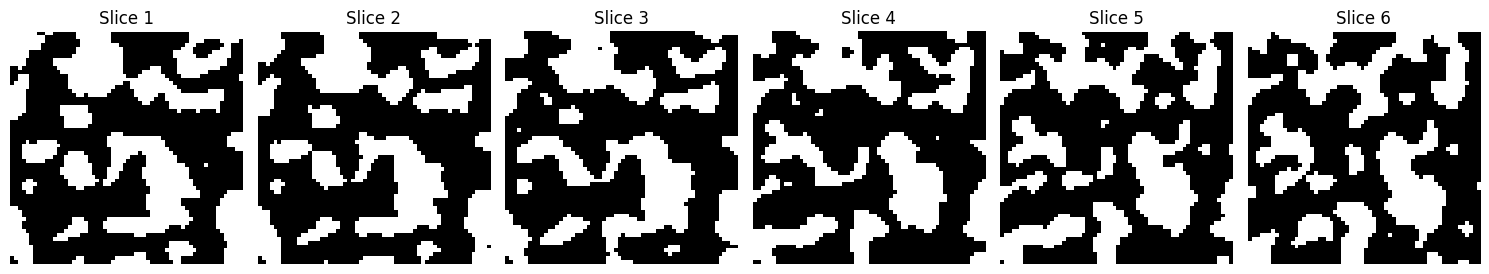

In [126]:
num_slices_to_show = 6
fig, axes = plt.subplots(1, num_slices_to_show, figsize=(15, 3))  # Create a figure with one row and multiple columns

for i in range(num_slices_to_show):
    axes[i].imshow(ori_slices[i], cmap='gray')  # Display using a grayscale image
    axes[i].set_title(f"Slice {i+1}")  # Set the title
    axes[i].axis('off')  # Turn off the axis

plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.show()

In [ ]:
num_slices_to_show = 6
fig, axes = plt.subplots(1, num_slices_to_show, figsize=(15, 3))  # Create a figure with one row and multiple columns

for i in range(num_slices_to_show):
    axes[i].imshow(re_slices[i], cmap='gray')  # Display using a grayscale image
    axes[i].set_title(f"Slice {i+1}")  # Set the title
    axes[i].axis('off')  # Turn off the axis

plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.show()